In [1]:
import numpy as np
from PIL import Image
from scipy.ndimage import convolve
import cv2
from scipy import ndimage
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)

def preprocess(image_name):
    # Tunable parameters. Can play around with these
    f = 11 # Boosting factor
    threshold = 30 # Threshold for binary image

    im = np.array(Image.open(image_name).convert("L"))

    # Sharpen image
    alpha = 0.05
    blurred = ndimage.gaussian_filter(im, 2)
    sharpened = im + alpha*(im-blurred)
    # new_img = Image.fromarray(sharpened.astype(np.uint8))
    # new_img.save("sharpened.jpg")

    # Opening operation
    element = np.array([[0,1,0],
                    [1,1,1],
                    [0,1,0]])
    im = opening(sharpened, element)

    # Boost filtering
    dx_filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    dy_filter = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = convolve(im, dx_filter).astype(float)
    Iy = convolve(im, dy_filter).astype(float)
    sobel_im = (Ix*Ix + Iy*Iy)**0.5
    for i in range(sobel_im.shape[0]):
        for j in range(sobel_im.shape[1]):
            if sobel_im[i][j] > 255:
                sobel_im[i][j] = 255.
    
    sobel_im = sobel_im/255.

    g = im/255.
    z = np.zeros(im.shape)
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            if sobel_im[i][j] > 0.5:
                z[i][j] = 0.4
            else:
                z[i][j] = 0.8
    w = np.zeros(im.shape)
    for i in range(w.shape[0]):
        for j in range(w.shape[1]):
            w[i][j] = (z[i][j]*(1 - sobel_im[i][j]) + (1-z[i][j])*(1-g[i][j])) * (f-8) + 8
    
    boosted_im = np.zeros(im.shape)
    for i in range(1, im.shape[0]-1):
        for j in range(1, im.shape[1]-1):
            high_boost_mask = 1/9*np.array([[-1, -1, -1], [-1, w[i][j], -1], [-1, -1, -1]], np.float32)
            temp = convolve(im[i-1:i+2, j-1:j+2], high_boost_mask)
            boosted_im[i][j] = temp[1][1]
    
    for i in range(1, im.shape[0]-1):
        for j in range(1, im.shape[1]-1):
            if boosted_im[i][j] > threshold:
                boosted_im[i][j] = 255
            else:
                boosted_im[i][j] = 0

    new_img = Image.fromarray(boosted_im.astype(np.uint8))
    new_img.save("boosted.jpg")
    return boosted_im

# Returns the neighbors of a given point
def neighbors(im, point):
    res = []
    for i in range(point[0]-1, point[0]+2):
        for j in range(point[1]-1, point[1]+2):
            if (i == point[0] and j == point[1]):
                continue
            if i > 0 and i < im.shape[0] and j > 0 and j < im.shape[1]:
                res.append((i,j))
    # if (point[0] < im.shape[0] - 1):
    #     res.append((point[0]+1, point[1]))
    # if (point[0] > 1):
    #     res.append((point[0]-1, point[1]))
    # if (point[1] < im.shape[1] - 1):
    #     res.append((point[0], point[1]+1))
    # if (point[1] > 1):
    #     res.append((point[0], point[1]-1))
    return res

def search(labeled_im, cur_label, r, c):
    stack = []
    stack.append((r,c))
    while stack:
        cur_node = stack.pop()
        labeled_im[cur_node[0]][cur_node[1]] = cur_label
        cur_neighbors = neighbors(labeled_im, cur_node)
        for i,j in cur_neighbors:
            if (labeled_im[i][j] == -1):
                stack.append((i,j))

def find_components(labeled_im):
    cur_label = 0
    for i in range(labeled_im.shape[0]):
        for j in range(labeled_im.shape[1]):
            if labeled_im[i][j] == -1:
                cur_label += 1
                search(labeled_im, cur_label, i, j)
    print(str(cur_label) + " connected components")
    return labeled_im, cur_label

def label(im):
    labeled_im = np.zeros(im.shape)
    for i in range(labeled_im.shape[0]):
        for j in range(labeled_im.shape[1]):
            if im[i][j] == 0:
                labeled_im[i][j] = -1
            else:
                labeled_im[i][j] = 0
    
    return find_components(labeled_im)

import random
def label_illustration(labeled_im):
    label_to_color = {}
    r_channel = np.zeros(labeled_im.shape)
    g_channel = np.zeros(labeled_im.shape)
    b_channel = np.zeros(labeled_im.shape)
    ctr = 0
    for i in range(labeled_im.shape[0]):
        for j in range(labeled_im.shape[1]):
            if labeled_im[i][j] == 0:
                r = 255
                g = 255
                b = 255
            elif labeled_im[i][j] in label_to_color:
                r = label_to_color[labeled_im[i][j]][0]
                g = label_to_color[labeled_im[i][j]][1]
                b = label_to_color[labeled_im[i][j]][2]
            else:
                r = random.randint(0,255)
                g = random.randint(0,255)
                b = random.randint(0,255)
                # ctr += 1
                # if (ctr > 19):
                #     r = 255
                #     g = 255
                #     b = 255
                label_to_color[labeled_im[i][j]] = (r, g, b)
                
            r_channel[i][j] = r
            g_channel[i][j] = g
            b_channel[i][j] = b
    
    new_img = Image.fromarray(np.dstack((r_channel, g_channel, b_channel)).astype(np.uint8))
    new_img.save("labeled_image.jpg")

# im = preprocess('data/test_face.jpg')
# im = preprocess('data/leonardo.jpg')
# labeled_im, cur_label = label(im)
# label_illustration(labeled_im)

############ Calculating centre of mass and orientation and grouping ############
def calculate_mu(x_coords, y_coords, x_bar, y_bar, p, q):
    mu = 0
    x_diff = np.power(y_coords - y_bar, p)
    y_diff = np.power(x_coords - x_bar, q)
    mu = np.sum(x_diff)
    mu += np.sum(y_diff)
    # for i in range(len(x_coords)):
    #     for j in range(len(y_coords)):
    #         mu += np.power((x_coords[i] - x_bar),p) * np.power((y_coords[j] - y_bar),q)
    return mu

def get_component_indices(labeled_im, num_labels):
    block_number_coords = np.zeros(num_labels)
    x_bar_all = np.zeros(num_labels)
    y_bar_all = np.zeros(num_labels)
    theta_all = np.zeros(num_labels)
    x_coords_all = []
    y_coords_all = []
    for cur_label in range(1, num_labels + 1):
        # print(cur_label)
        x_coords = np.where( labeled_im == cur_label )[0] 
        y_coords = np.where( labeled_im == cur_label )[1] 
        x_coords_all.append(x_coords)
        y_coords_all.append(y_coords)
        block_number_coords[cur_label - 1] = len(x_coords)

        x_bar_all[cur_label - 1] = np.average(x_coords)
        y_bar_all[cur_label - 1] = np.average(y_coords)

        if (len(x_coords)>5000 or len(y_coords)>5000 or num_labels > 100):
            continue
        mu_1_1 = calculate_mu(x_coords, y_coords, x_bar_all[cur_label - 1], y_bar_all[cur_label - 1], 1, 1)
        mu_2_0 = calculate_mu(x_coords, y_coords, x_bar_all[cur_label - 1], y_bar_all[cur_label - 1], 2, 0)
        mu_0_2 = calculate_mu(x_coords, y_coords, x_bar_all[cur_label - 1], y_bar_all[cur_label - 1], 0, 2)

        if (mu_2_0 - mu_0_2) == 0: 
            continue
        theta_all[cur_label - 1] = 0.5 * ( np.arctan2( 2*mu_1_1, (mu_2_0 - mu_0_2) ) )

    return x_bar_all, y_bar_all, theta_all, block_number_coords, x_coords_all, y_coords_all

# test_im = np.zeros((100,100))
# for i in range(45,55):
#     test_im[50][i] = 1.
#     test_im[51][i] = 1.
#     test_im[60][i] = 2.
#     test_im[61][i] = 2.
#     test_im[i][98] = 3.
#     test_im[i][99] = 3.
# x_bar_all, y_bar_all, theta_all, block_number_coords, x_coords_all, y_coords_all = get_component_indices(test_im, 3)
# print(x_bar_all)
# print(y_bar_all)
# print(theta_all)
# print(block_number_coords)
# print(x_coords_all)
# print(y_coords_all)

def find_blocks_within_radius(cur_block_idx, labeled_im, x_bar, y_bar, radius):
    min_y = int(np.floor(y_bar - radius))
    max_y = int(np.ceil(y_bar + radius))

    blocks_within_radius = []
    for y in range(min_y + 1, max_y):
        # From the formula: r^2 = (x-h)^2 + (y-k)^2, where 
        # h,k are the distances from x,y respectively
        x_diff = np.power(radius,2) - np.power(y-y_bar,2)
        min_x = int(np.floor(x_bar - x_diff))
        max_x = int(np.ceil(x_bar + x_diff))

        for x in range(min_x + 1, max_x):
            if x < labeled_im.shape[0] and y < labeled_im.shape[1] and labeled_im[x,y] != 0 and labeled_im[x,y] != cur_block_idx+1:
                if labeled_im[x,y] not in blocks_within_radius:
                    blocks_within_radius.append(labeled_im[x,y])
    return blocks_within_radius


def find_nearest_block(cur_block_idx, blocks_within_radius, x_bar, y_bar, radius):
    min_distance_block = None
    min_distance = np.inf
    for block in blocks_within_radius:
        x_dist = np.power(x_bar[int(block - 1)] - x_bar[cur_block_idx], 2)
        y_dist = np.power(y_bar[int(block - 1)] - y_bar[cur_block_idx], 2)
        distance_to_cur_block = np.sqrt(x_dist + y_dist)
        if distance_to_cur_block < min_distance and distance_to_cur_block <= radius:
            min_distance = distance_to_cur_block
            min_distance_block = block

    return min_distance_block 

def grouping(labeled_im, cur_label, block_number_coords, x_bar, y_bar, x_coords_all, y_coords_all):
    N_max = 100 #??????? This changes based on the image - need to test different values
    for N in range(1, N_max + 1):
        radius = 8 - ( 6 * ( (N - 1) / (N_max - 1) ) )
        count = 0
        for i in range(cur_label):
            blocks_within_radius = []
            if block_number_coords[i] == N:
                blocks_within_radius = find_blocks_within_radius(i, labeled_im, x_bar[i], y_bar[i], radius)
            else:
                continue

            if len(blocks_within_radius) > 0:
                nearest_block = find_nearest_block(i, blocks_within_radius, x_bar, y_bar, radius)
                if nearest_block is None:
                    continue
                nearest_block = int(nearest_block)
            else:
                continue

            #lies on same axis if any of the x coordinates are the same
            # lies_on_same_axis = bool(set(x_coords_all[nearest_block - 1]) & set(x_coords_all[i]))
            # lies_on_same_axis = False
            # if block_number_coords[nearest_block - 1] < N_max or lies_on_same_axis:
            block_to_merge_with = max(i + 1, nearest_block)
            block_to_merge = min(i + 1, nearest_block)

            # print(str(i+1) + " " + str(nearest_block))
            # print(str(block_to_merge_with) + " " + str(block_to_merge))

            x_coords = x_coords_all[block_to_merge - 1]
            y_coords = y_coords_all[block_to_merge - 1]

            labeled_im[x_coords, y_coords] = block_to_merge_with
            block_number_coords[block_to_merge_with-1] = block_number_coords[block_to_merge_with-1] + block_number_coords[block_to_merge-1]
            block_number_coords[block_to_merge-1] = 0
            new_x_coords = np.append(x_coords_all[block_to_merge_with-1], x_coords)
            new_y_coords = np.append(y_coords_all[block_to_merge_with-1], y_coords)
            x_coords_all[block_to_merge_with-1] = new_x_coords
            y_coords_all[block_to_merge_with-1] = new_y_coords
            x_coords_all[block_to_merge-1] = np.array([])
            y_coords_all[block_to_merge-1] = np.array([])

    return labeled_im

# Make labels consecutive in order after grouping
def relabel_grouped_im(labeled_im, num_labels):
    old_label_to_new_map = {}
    ctr = 0
    for i in range(labeled_im.shape[0]):
        for j in range(labeled_im.shape[1]):
            if labeled_im[i][j] == 0:
                continue
            if labeled_im[i][j] not in old_label_to_new_map:
                ctr += 1
                old_label_to_new_map[labeled_im[i][j]] = ctr
            labeled_im[i][j] = old_label_to_new_map[labeled_im[i][j]]
    if ctr != num_labels:
        print("something broke")
        print(ctr)
        print(num_labels)

# For testing
def use_only_good_labels(labeled_im, labels_to_use):
    num_labels = len(labels_to_use)
    old_label_to_new_map = {}
    ctr = 0
    for i in range(labeled_im.shape[0]):
        for j in range(labeled_im.shape[1]):
            if labeled_im[i][j] == 0:
                continue
            if labeled_im[i][j] not in labels_to_use:
                labeled_im[i][j] = 0
                continue
            if labeled_im[i][j] not in old_label_to_new_map:
                ctr += 1
                old_label_to_new_map[labeled_im[i][j]] = ctr
            labeled_im[i][j] = old_label_to_new_map[labeled_im[i][j]]
    if ctr != num_labels:
        print("something broke")
        print(ctr)
        print(num_labels)

            
# Default 60 length for testing
# Need to find a way to find length of semimajor axis
def get_block_lengths(x_bar_all, y_bar_all, theta_all, x_coords_all, y_coords_all):
    block_lengths = np.zeros(len(theta_all))
    alpha_max = np.zeros(len(theta_all))
    alpha_min = np.zeros(len(theta_all))
    beta_max = np.zeros(len(theta_all))
    beta_min = np.zeros(len(theta_all))
    for i in range(len(block_lengths)):
        # if i == 8: print(x_coords_all[i], y_coords_all[i], theta_all[i])
        x = np.linspace(min(x_coords_all[i]), max(x_coords_all[i]), num=max(x_coords_all[i]) - min(x_coords_all[i]) + 1)
        y = np.linspace(min(y_coords_all[i]), max(y_coords_all[i]), num=max(y_coords_all[i]) - min(y_coords_all[i]) + 1)
        # print(min(x_coords_all[i]), max(x_coords_all[i]))
        # print(min(y_coords_all[i]), max(y_coords_all[i]))
        # if i == 0: print(x,y)
        max_x = -np.Inf
        max_y = -np.Inf
        min_x = np.Inf
        min_y = np.Inf
        for a in x:
            for j in y:
                alpha = a * np.cos(theta_all[i]) + j * np.sin(theta_all[i])
                beta = -a * np.sin(theta_all[i]) + j * np.cos(theta_all[i]) 
                if alpha < min_x:
                    min_x = alpha
                if alpha > max_x:
                    max_x = alpha
                if beta < min_y:
                    min_y = beta
                if beta > max_y:
                    max_y = beta
        block_lengths[i] = max(max_x - min_x, max_y - min_y)
        # block_lengths[i] = max(max(x_coords_all[i]) - min(x_coords_all[i]), max(y_coords_all[i]) - min(y_coords_all[i]))
        # alpha_max[i] = x_bar_all[i] + max_x
        # alpha_min[i] = x_bar_all[i] - min_x
        # beta_max[i] = y_bar_all[i] + max_y
        # beta_min[i] = y_bar_all[i] - min_y

        alpha_max[i] = max(x_coords_all[i])
        alpha_min[i] = min(x_coords_all[i])
        beta_max[i] = max(y_coords_all[i])
        beta_min[i] = min(y_coords_all[i])
    # print('xxxxxxxxx')
    # print(alpha_max, alpha_min, beta_max, beta_min)
    # print('xxxxxxxxx')
#         block_lengths[i] = 60
    # print(min(x_coords_all[i]), max(x_coords_all[i]))
    return block_lengths, alpha_max, alpha_min, beta_max, beta_min

def remove_small_blocks(labeled_im, block_number_coords, threshold = 30):
    for i in range(labeled_im.shape[0]):
        for j in range(labeled_im.shape[1]):
            if block_number_coords[int(labeled_im[i][j] - 1)] < threshold:
                labeled_im[i][j] = 0
    
    num_labels = len(np.unique(labeled_im)) - 1
    relabel_grouped_im(labeled_im, num_labels)

In [2]:
import numpy as np
import math
from tqdm import tqdm
class Block:
    def __init__(self,xcenter,ycenter,theta,length):
        #xcenter, ycenter: The center of our block
        #Theta: The orientation of the block
        #Length: The length of semimajor axis
        self.x = ycenter
        self.y = xcenter
        self.angle = theta
        self.length = length

    def GetCenter(self):
        return (self.x,self.y)

    def GetAngle(self):
        return self.angle

    def GetLength(self):
        return self.length

    def ComputeDistance(self,other):
        x2,y2 = other.GetCenter()
        return np.sqrt((self.x-x2)**2+(self.y-y2)**2)

def Baseline(block1,block2,threshold=0.7):
    x1,y1 = block1.GetCenter()
    x2,y2 = block2.GetCenter()
    a = y2-y1
    b = x1-x2
    if b == 0:
        return []
    c = x2 * y1 - x1 * y2
    theta = math.atan(-a/b)
    if theta < math.pi * -1/2 or theta >= math.pi/2:
        return []
    #print(a,b,c)
    D = block1.ComputeDistance(block2)
    l1 = block1.GetLength()/D
    l2 = block2.GetLength()/D
    ep =  (l1 - l2)**2
    ep += (l1 + l2-1)**2
    ep += (block1.GetAngle() - theta)**2
    ep += (block2.GetAngle() - theta)**2
    ep = -1.2 *ep
    score = math.exp(ep)
    #print(score)
    if score < threshold:
        return []

    return [a,b,c,D,score]

def ComputeProbability(a,b,c,D,block,factor):
    x,y = block.GetCenter()
    d = np.abs(a*x+b*y+c)/np.sqrt(a**2+b**2)
    dlocal = factor * D
    ep = (d - dlocal)/D
    ep =-4.8 * (ep ** 2)
    return math.exp(ep)

def TotalProbability(le,re,reb,leb,mouth,nose,Weights=[0.5,0.2,0.1,0.1,0.1],Factors=[1,0.3,0.6],threshold=0.7):
    #We add additional constraint here
    
    lex,ley = le.GetCenter()
    rex,rey = re.GetCenter()
    #Left eye should be on the left
    if lex >= rex:
        return 0
    
    lebx,leby = leb.GetCenter()
    rebx,reby = reb.GetCenter()
    
    #Eyebrow should be above eyes
    if leby > ley:
        return 0
    if lebx >= rebx:
        return 0
    if reby > rey:
        return 0
    
    mx,my = mouth.GetCenter()
    nx,ny = nose.GetCenter()
    
    #Mouth and nose should be in-between
    if mx > rebx or mx < lebx:
        return 0
    if nx > rebx or nx < lebx:
        return 0
    
    #Mouth should be below the nose
    if my < ny:
        return 0
    if ny < ley or ny < rey:
        return 0
    
    ret = Baseline(re,le,threshold)
    if len(ret) == 0:
        return 0
    
    a,b,c,D,score = ret
    
    eyelength = max(le.GetLength(),re.GetLength())
    if leb.GetLength() > 2.5 * eyelength:
        return 0
    if reb.GetLength() > 2.5 * eyelength:
        return 0
    
    if nose.GetLength() > 3 * eyelength:
        return 0
    
    if mouth.GetLength() > 4 * eyelength:
        return 0
    
    score = score * Weights[0]
    score += Weights[1] * ComputeProbability(a,b,c,D,mouth,Factors[0])
    score += Weights[2] * ComputeProbability(a,b,c,D,reb,Factors[1])
    score += Weights[3] * ComputeProbability(a,b,c,D,leb,Factors[1])
    score += Weights[4] * ComputeProbability(a,b,c,D,nose,Factors[2])
    return score

def Matching(blocks):
    scores = []
    indices = []
    length = len(blocks)
    for le in tqdm(range(length)):
        
        for re in range(length):
            if re == le:
                continue
            ret = Baseline(blocks[le],blocks[re])
            if len(ret) == 0:
                continue

            for reb in range(length):
                if reb == le or reb == re:
                    continue

                for leb in range(length):
                    if leb == le or leb == re or leb == reb:
                        continue

                    for mouth in range(length):
                        if mouth == reb or mouth == leb or mouth == le or mouth == re:
                            continue

                        for nose in range(length):
                            if nose == mouth or nose == reb or nose == leb or nose == le or nose == re:
                                continue
                            score = TotalProbability(blocks[le],blocks[re],blocks[reb],blocks[leb],blocks[mouth],blocks[nose]) 
                            if score > 0.5:
                                scores.append(score)
                                indices.append((le,re,reb,leb,mouth,nose))
    if len(scores) == 0:
        return []
    
    max_idx = np.argmax(scores)

    print("The block # for left eye, right eye, left eyebrow, right eyebrow, mouth and nose are ",indices[max_idx])
    print("The score is ",scores[max_idx])
    return indices[max_idx]

In [9]:
im = preprocess("test1.png")
labeled_im, cur_label = label(im)
x_bar_all, y_bar_all, theta_all, block_number_coords, x_coords_all, y_coords_all = get_component_indices(labeled_im, cur_label)
labeled_im = grouping(labeled_im, cur_label, block_number_coords, x_bar_all, y_bar_all, x_coords_all, y_coords_all)
print(str(len(np.unique(labeled_im)) - 1) + " Connected Components")
num_labels = len(np.unique(labeled_im)) - 1
relabel_grouped_im(labeled_im, num_labels)

# good_labels = {20, 21, 22, 23, 24, 25}
# use_only_good_labels(labeled_im, good_labels)
# num_labels = len(np.unique(labeled_im)) - 1
label_illustration(labeled_im)

x_bar_all, y_bar_all, theta_all, block_number_coords, x_coords_all, y_coords_all = get_component_indices(labeled_im, num_labels)
block_lengths, alpha_max, alpha_min, beta_max, beta_min = get_block_lengths(x_bar_all, y_bar_all, theta_all, x_coords_all, y_coords_all)
print("block lengths")
# print(x_bar_all, y_bar_all)
print(block_lengths)
print("block lengths end")
# print(x_bar_all)
# print(y_bar_all)
# print(theta_all)

block_indices = []
blocks = []
for i in range(len(block_lengths)):
    if block_lengths[i] > 20:
        blocks.append(Block(x_bar_all[i], y_bar_all[i], theta_all[i], block_lengths[i]))
        block_indices.append(i)
        

1358 connected components
96 Connected Components
block lengths
[612. 576. 611. 408.   0.   0.   8.   3.   2.  10.   0.   0.   7.   2.
   0.   0.   1.   2.   6.   2. 104.  70.   0.   8.   0.   2.   1.  65.
   0.  98.   8.  20.   0.   8.   3.  11.   0.   5.   1.   4.  18.   7.
   9.   0.   0.   4.   2.   3.   8.   0.   2.   0.   5.  13.  13.  37.
  15.   0.   0.   3.   3. 102.   0.  14.   1.   0.   5.   3.  63.   3.
  17.   0.  76.   0.   7.   7.   1.   9.   5.  45.  12.   0.   6.   8.
   6.   8.   6.   2.   6.  10.   9.  18.  11.   0.   0.   6.]
block lengths end


In [10]:
ret = Matching(blocks)

100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 210.24it/s]

187
The block # for left eye, right eye, left eyebrow, right eyebrow, mouth and nose are  (7, 6, 0, 2, 9, 8)
The score is  0.915892745857174


In [11]:
final = []
for each in ret:
    final.append(block_indices[each])

In [12]:
face_locations = []
for each in final:
    #x,y = blocks[each].GetCenter()
    top = int(alpha_min[each])
    bottom = int(alpha_max[each])
    left = int(beta_min[each])
    right = int(beta_max[each])
    face_locations.append([top,right,bottom,left])


In [13]:
print(face_locations)

[[327, 291, 364, 193], [323, 406, 353, 341], [0, 577, 612, 0], [1, 0, 612, 0], [476, 339, 499, 237], [429, 304, 455, 267]]


In [15]:
DrawRectangles("test1.png",face_locations[2:4])

(613, 578, 3)
test1_out.jpg


(504, 450, 3)
_out.jpg


In [3]:
def DrawRectangles(filename,face_locations):
    #start = time.time()
    image = cv2.imread(filename)
    print(image.shape)
    height = image.shape[0]
    width = image.shape[1]
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    for each in face_locations:
        top,right,bottom,left = each
        for i in range(left,right):
            B[top][i] = 255
            B[top+1][i] = 255
            if top-1 >= 0:
                B[top-1][i] = 255
            B[bottom][i] = 255
            if bottom + 1 < height:
                B[bottom+1][i] = 255
            B[bottom-1][i] = 255
            
        for j in range(top,bottom):
            B[j][left] = 255
            B[j][right] = 255
            B[j][left+1] = 255
            
            if left - 1 >= 0:
                B[j][left-1] = 255
            if right + 1 < width:
                B[j][right+1] = 255
            B[j][right-1] = 255
    
    
    outfile = filename.split(".")[0] + "_out.jpg"
    print(outfile)
    im = Image.fromarray(np.stack([B,G,R],axis=2))
    #im.show()
    cv2.imwrite(outfile,np.stack([R,G,B],axis=2))
    
def PrintAllBlocks(image_name,block_indices = None):
    im = preprocess(image_name)
    labeled_im, cur_label = label(im)
    x_bar_all, y_bar_all, theta_all, block_number_coords, x_coords_all, y_coords_all = get_component_indices(labeled_im, cur_label)
    labeled_im = grouping(labeled_im, cur_label, block_number_coords, x_bar_all, y_bar_all, x_coords_all, y_coords_all)
    print(str(len(np.unique(labeled_im)) - 1) + " Connected Components")
    num_labels = len(np.unique(labeled_im)) - 1
    relabel_grouped_im(labeled_im, num_labels)

    # good_labels = {20, 21, 22, 23, 24, 25}
    # use_only_good_labels(labeled_im, good_labels)
    # num_labels = len(np.unique(labeled_im)) - 1
    label_illustration(labeled_im)

    x_bar_all, y_bar_all, theta_all, block_number_coords, x_coords_all, y_coords_all = get_component_indices(labeled_im, num_labels)
    block_lengths, alpha_max, alpha_min, beta_max, beta_min = get_block_lengths(x_bar_all, y_bar_all, theta_all, x_coords_all, y_coords_all)
    face_locations = []
    for i in range(len(block_lengths)):
        if block_indices is not None and i not in block_indices:
            continue
        
        top = int(alpha_min[i])
        bottom = int(alpha_max[i])
        left = int(beta_min[i])
        right = int(beta_max[i])
        face_locations.append([top,right,bottom,left])
        
    DrawRectangles(image_name,face_locations)
    

In [4]:
def DrawRectanglesFinal(filename,face_locations):
    #start = time.time()
    image = cv2.imread(filename)
    #print(image.shape)
    height = image.shape[0]
    width = image.shape[1]
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    for each in face_locations:
        top,right,bottom,left = each
        for i in range(left,right):
            B[top][i] = 255
            B[top+1][i] = 255
            if top-1 >= 0:
                B[top-1][i] = 255
            B[bottom][i] = 255
            if bottom + 1 < height:
                B[bottom+1][i] = 255
            B[bottom-1][i] = 255
            
        for j in range(top,bottom):
            B[j][left] = 255
            B[j][right] = 255
            B[j][left+1] = 255
            
            if left - 1 >= 0:
                B[j][left-1] = 255
            if right + 1 < width:
                B[j][right+1] = 255
            B[j][right-1] = 255
    
    
    outfile = filename.split(".")[0] + "_final.jpg"
    #print(outfile)
    im = Image.fromarray(np.stack([B,G,R],axis=2))
    #im.show()
    cv2.imwrite(outfile,np.stack([R,G,B],axis=2))

In [5]:
def FaceDetection(image_name,threshold = 20):
    im = preprocess(image_name)
    labeled_im, cur_label = label(im)
    x_bar_all, y_bar_all, theta_all, block_number_coords, x_coords_all, y_coords_all = get_component_indices(labeled_im, cur_label)
    labeled_im = grouping(labeled_im, cur_label, block_number_coords, x_bar_all, y_bar_all, x_coords_all, y_coords_all)
    print(str(len(np.unique(labeled_im)) - 1) + " Connected Components")
    num_labels = len(np.unique(labeled_im)) - 1
    relabel_grouped_im(labeled_im, num_labels)

    # good_labels = {20, 21, 22, 23, 24, 25}
    # use_only_good_labels(labeled_im, good_labels)
    # num_labels = len(np.unique(labeled_im)) - 1
    label_illustration(labeled_im)

    x_bar_all, y_bar_all, theta_all, block_number_coords, x_coords_all, y_coords_all = get_component_indices(labeled_im, num_labels)
    block_lengths, alpha_max, alpha_min, beta_max, beta_min = get_block_lengths(x_bar_all, y_bar_all, theta_all, x_coords_all, y_coords_all)
    print("block lengths")
    # print(x_bar_all, y_bar_all)
    print(block_lengths)
    print("block lengths end")
    # print(x_bar_all)
    # print(y_bar_all)
    # print(theta_all)


    block_indices = []
    blocks = []
    for i in range(len(block_lengths)):
        if block_lengths[i] > threshold:
            blocks.append(Block(x_bar_all[i], y_bar_all[i], theta_all[i], block_lengths[i]))
            block_indices.append(i)

    ret = Matching(blocks)
    
    final = []
    for each in ret:
        final.append(block_indices[each])
    face_locations = []
    for each in final:
        #x,y = blocks[each].GetCenter()
        top = int(alpha_min[each])
        bottom = int(alpha_max[each])
        left = int(beta_min[each])
        right = int(beta_max[each])
        face_locations.append([top,right,bottom,left])
    
    DrawRectangles(image_name,face_locations)

In [27]:
FaceDetection("test_face.jpg")

1397 connected components
201 Connected Components


 44%|████████████████████████████████████▎                                              | 7/16 [00:00<00:00, 50.13it/s]

block lengths
[348. 159. 503. 287.   3.   6.   7.   7.  13.  10.   4.   0.   0.  10.
   0.   0.   1.   3.   0.   1.   7.  15.   0.   0.   9.   3.   2.   3.
  16.   0.   1.  41.   0.  85.   0.   0.   0.  57.   2.  14.   0.   3.
   0.  11.   2.   3.   0.   0.   0.  71.   4.   1.   5.   7.   5.   2.
  10.  68.   4.   0.   4.  12.   1.   1.   0.   1.   9.   7.   3.   6.
   7.   4.  10.   0.   1.  10.   0.   4.   0.   0.   5.   7.  13.  13.
   8.   1.  28.   0.   0.  65.  10.   6.   8.   0.   2.  11.   8.   0.
   0.   4.   4.   7.   0.  10.   5.   2.  12.   3.   0.   0.   1.   0.
   4.   2.   1.   0.   2.   1.  10.  11.  12. 110.   6.   0.  21.   8.
   8.   8.  25.   5.   7.   0.   2.   4.   1.   2.  15.  10.   8.   3.
   5.   6.  37.   5.   9.  19.   5. 128.   2.   0.   7.   0.   5.   5.
   5.   0.   7.   0.   5.  10.  13.   0.  10.   2.   0.   1.   5.   7.
   4.   1.   2.   5.   7.   1.   9.   2.   6.   2.   0.   2.   8.   0.
  14.   1.   7.   9.   2.   9.   6.   2.   7.   7.   0.   3.   

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 48.76it/s]


49
The block # for left eye, right eye, left eyebrow, right eyebrow, mouth and nose are  (8, 7, 4, 6, 11, 10)
The score is  0.9813515842626044
(504, 450, 3)
test_face_out.jpg


In [6]:
def FaceDetectionFinal(image_name,threshold = 20):
    import time
    time1 = time.time()
    im = preprocess(image_name)
    labeled_im, cur_label = label(im)
    time2 = time.time()
    x_bar_all, y_bar_all, theta_all, block_number_coords, x_coords_all, y_coords_all = get_component_indices(labeled_im, cur_label)
    labeled_im = grouping(labeled_im, cur_label, block_number_coords, x_bar_all, y_bar_all, x_coords_all, y_coords_all)
    #print(str(len(np.unique(labeled_im)) - 1) + " Connected Components")
    time3 = time.time()
    num_labels = len(np.unique(labeled_im)) - 1
    relabel_grouped_im(labeled_im, num_labels)

    # good_labels = {20, 21, 22, 23, 24, 25}
    # use_only_good_labels(labeled_im, good_labels)
    # num_labels = len(np.unique(labeled_im)) - 1
    label_illustration(labeled_im)

    x_bar_all, y_bar_all, theta_all, block_number_coords, x_coords_all, y_coords_all = get_component_indices(labeled_im, num_labels)
    block_lengths, alpha_max, alpha_min, beta_max, beta_min = get_block_lengths(x_bar_all, y_bar_all, theta_all, x_coords_all, y_coords_all)
    # print(x_bar_all)
    # print(y_bar_all)
    # print(theta_all)
    time4 = time.time()

    block_indices = []
    blocks = []
    for i in range(len(block_lengths)):
        if block_lengths[i] > threshold:
            blocks.append(Block(x_bar_all[i], y_bar_all[i], theta_all[i], block_lengths[i]))
            block_indices.append(i)

    ret = Matching(blocks)
    if len(ret) == 0:
        return [time2-time1,time3-time2,time4-time3,time.time()-time4,time.time()-time1]
    
    
    final = []
    for each in ret:
        final.append(block_indices[each])
    face_locations = []
    for each in final:
        #x,y = blocks[each].GetCenter()
        top = int(alpha_min[each])
        bottom = int(alpha_max[each])
        left = int(beta_min[each])
        right = int(beta_max[each])
        face_locations.append([top,right,bottom,left])
    

    dummy1 = np.max(np.array(face_locations),axis=0)
    dummy2 = np.min(np.array(face_locations),axis=0)
    face_locations = [[dummy2[0],dummy1[1],dummy1[2],dummy2[3]]]
    DrawRectanglesFinal(image_name,face_locations)
    #Preprocessing time, Block time, Grouping time, Matching Time, Total time
    return [time2-time1,time3-time2,time4-time3,time.time()-time4,time.time()-time1]

In [18]:
PrintAllBlocks("test4.png")

1614 connected components
239 Connected Components
block lengths
[566. 429. 566.  69.  16.   9.  17.   5.  30.  19.   9.   4.   8.  18.
   9.  34.   8.  61.   3.   9.   0.   1.  24.   8.  11.  37.   4.  32.
  10.   6.   4.   3.  33.   0.   8.   5.  14.  36.   3.   8.  10.  11.
   4.   3.  11.  13.   1.   7.  10.   9.   0.  14.   9.   5.   7.  28.
   6.  23.   0.  21.   9.   2.  12.  19.  12.   3.   9.  15.   3.   8.
   7.   9.   6.  11.   4.   7.  13.  13.   2.   2.   1.   4.   8.   4.
   7.   9.   9.   0.  17.   9.   7.   5.   5.  11.   7.   0.   4.  14.
   7.  12.  11.  13.   0.   0.   9.   6.   0.   0.  19.   2.   3.  12.
   7.   7.   6.   3.   5.   1.   8.   0.   2.   6.  21.   7.   6.   3.
   5.   5.   6.   0.   4.   1.   2.   0.   8.   1.  11.   5.   5.  12.
   8.  12.   1.  13.   8.  14.  10.   0.  16.  78.   8.  11.  21.  73.
   2.  57.  18.   0.   6.   6.  11.  20.   2.  17.   7.  10.  37.  14.
   9.   0.   7.   3.  12.   5.   7.   0.  10.  11.   2.  11.  10.  13.
  14.   0.  

In [7]:
testset = []
for i in range(1,21):
    testset.append("test" + str(i)+".jpg")
print(testset)
    

['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg', 'test7.jpg', 'test8.jpg', 'test9.jpg', 'test10.jpg', 'test11.jpg', 'test12.jpg', 'test13.jpg', 'test14.jpg', 'test15.jpg', 'test16.jpg', 'test17.jpg', 'test18.jpg', 'test19.jpg', 'test20.jpg']


In [8]:
pretime = []
ccdtime = []
grptime = []
mattime = []
tottime = []
for each in testset:
    p,b,g,m,t = FaceDetectionFinal(each)
    pretime.append(p)
    ccdtime.append(b)
    grptime.append(g)
    mattime.append(m)
    tottime.append(t)

1397 connected components


100%|██████████| 16/16 [00:00<00:00, 44.12it/s]


The block # for left eye, right eye, left eyebrow, right eyebrow, mouth and nose are  (8, 7, 4, 6, 11, 10)
The score is  0.9813515842626044
1358 connected components


100%|██████████| 13/13 [00:00<00:00, 198.05it/s]


The block # for left eye, right eye, left eyebrow, right eyebrow, mouth and nose are  (7, 6, 5, 4, 9, 8)
The score is  0.9148909749463681
812 connected components


100%|██████████| 12/12 [00:00<00:00, 406.70it/s]


The block # for left eye, right eye, left eyebrow, right eyebrow, mouth and nose are  (8, 6, 4, 5, 11, 9)
The score is  0.8830144119104031
941 connected components


100%|██████████| 17/17 [00:00<00:00, 51.37it/s]


The block # for left eye, right eye, left eyebrow, right eyebrow, mouth and nose are  (7, 8, 5, 4, 12, 11)
The score is  0.9956876102792934
1695 connected components


100%|██████████| 18/18 [00:00<00:00, 31.07it/s]


1614 connected components


100%|██████████| 29/29 [00:30<00:00,  1.06s/it]


The block # for left eye, right eye, left eyebrow, right eyebrow, mouth and nose are  (23, 22, 18, 20, 28, 27)
The score is  0.9579465561559352
780 connected components


100%|██████████| 9/9 [00:00<00:00, 1517.72it/s]


The block # for left eye, right eye, left eyebrow, right eyebrow, mouth and nose are  (6, 5, 3, 4, 8, 7)
The score is  0.9719396855819296
1030 connected components


100%|██████████| 11/11 [00:00<00:00, 379.04it/s]


1072 connected components


100%|██████████| 9/9 [00:00<00:00, 1210.87it/s]


524 connected components


100%|██████████| 5/5 [00:00<00:00, 17232.14it/s]


1253 connected components


100%|██████████| 7/7 [00:00<00:00, 12688.04it/s]


724 connected components


100%|██████████| 6/6 [00:00<00:00, 18091.89it/s]


528 connected components


100%|██████████| 4/4 [00:00<00:00, 16513.01it/s]


1358 connected components


100%|██████████| 14/14 [00:00<00:00, 551.67it/s]


1309 connected components


100%|██████████| 11/11 [00:00<00:00, 9642.08it/s]


462 connected components


100%|██████████| 4/4 [00:00<00:00, 22133.53it/s]


492 connected components


100%|██████████| 3/3 [00:00<00:00, 20901.85it/s]


741 connected components


100%|██████████| 7/7 [00:00<00:00, 7296.25it/s]


1249 connected components


100%|██████████| 11/11 [00:00<00:00, 406.79it/s]


The block # for left eye, right eye, left eyebrow, right eyebrow, mouth and nose are  (7, 6, 4, 5, 10, 8)
The score is  0.963368575269011
506 connected components


100%|██████████| 5/5 [00:00<00:00, 9772.38it/s]


In [11]:
import face_recognition
import time
def HandleOneImage(filename):
    start = time.time()
    image = face_recognition.load_image_file(filename)
    face_locations = face_recognition.face_locations(image)
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    for each in face_locations:
        top,right,bottom,left = each
        for i in range(left,right):
            R[top][i] = 255
            R[top+1][i] = 255
            R[top-1][i] = 255
            R[bottom][i] = 255
            R[bottom+1][i] = 255
            R[bottom-1][i] = 255
            
        for j in range(top,bottom):
            R[j][left] = 255
            R[j][right] = 255
            R[j][left+1] = 255
            R[j][right+1] = 255
            R[j][left-1] = 255
            R[j][right-1] = 255
    
    
    outfile = filename.split(".")[0] + "_out.jpg"
    
    cv2.imwrite(outfile,np.stack([B,G,R],axis=2))
    return time.time()-start

In [12]:
baseline = []
for each in testset:
    baseline.append(HandleOneImage(each))

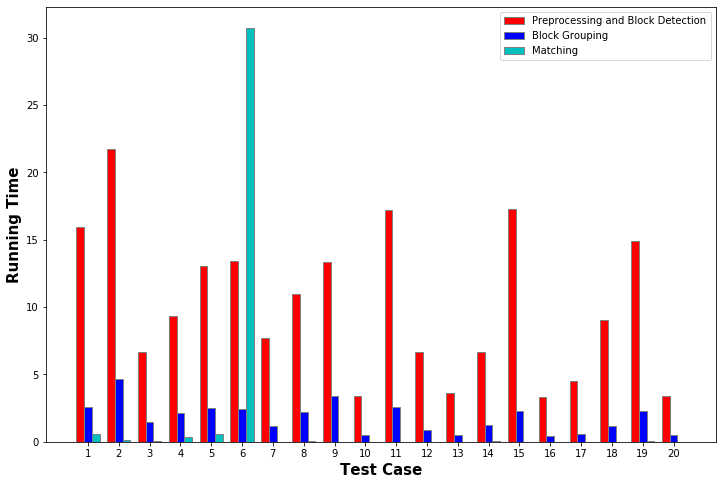

In [19]:
import numpy as np
import matplotlib.pyplot as plt
 

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(testset))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, np.array(pretime)+np.array(ccdtime), color ='r', width = barWidth,
        edgecolor ='grey', label ='Preprocessing and Block Detection')
#plt.bar(br2, ccdtime, color ='g', width = barWidth,
        #edgecolor ='grey', label ='Block Detection')
plt.bar(br2, grptime, color ='b', width = barWidth,
        edgecolor ='grey', label ='Block Grouping')
plt.bar(br3, mattime, color ='c', width = barWidth,
        edgecolor ='grey', label ='Matching')
 
# Adding Xticks
plt.xlabel('Test Case', fontweight ='bold', fontsize = 15)
plt.ylabel('Running Time', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(testset))],
        [str(i) for i in range(1,21)])
plt.legend()
plt.show()

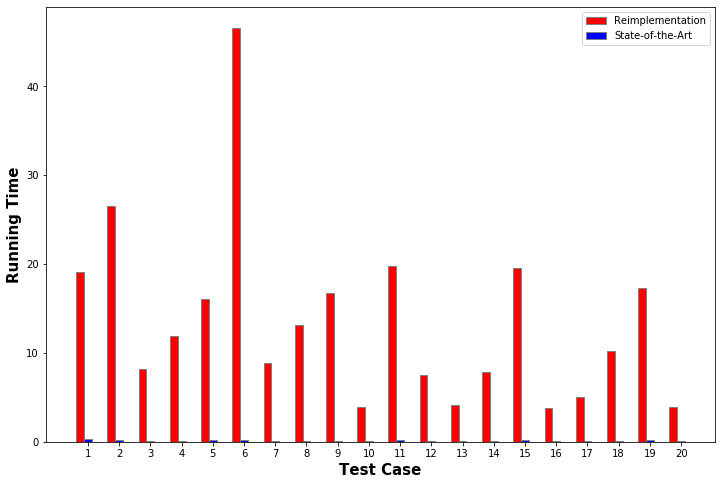

In [20]:
import numpy as np
import matplotlib.pyplot as plt
 

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(testset))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, tottime, color ='r', width = barWidth,
        edgecolor ='grey', label ='Reimplementation')
#plt.bar(br2, ccdtime, color ='g', width = barWidth,
        #edgecolor ='grey', label ='Block Detection')
plt.bar(br2, baseline, color ='b', width = barWidth,
        edgecolor ='grey', label ='State-of-the-Art')
#plt.bar(br3, mattime, color ='c', width = barWidth,
#        edgecolor ='grey', label ='Matching')
 
# Adding Xticks
plt.xlabel('Test Case', fontweight ='bold', fontsize = 15)
plt.ylabel('Running Time', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(testset))],
        [str(i) for i in range(1,21)])
plt.legend()
plt.show()

In [22]:
print(np.mean(baseline))

0.12229474782943725
